<center> <h1>Αναγνώριση Προτύπων - 2η Εργαστηριακή Άσκηση</h1> </center>

---

<center> <h2>Θέμα: Αναγνώριση φωνής με Κρυφά Μαρκοβιανά Μοντέλα και Αναδρομικά Νευρωνικά Δίκτυα</h2> </center>
<center> <h2>ΣΧΟΛΗ: ΣΗΜΜΥ</h2> </center>
<img src="pyrforos-digamma.png" width="100">

Ονοματεπώνυμο | Αριθμός Μητρώου
------------ | -------------
Γιάννης Πιτόσκας | 03115077
Αντώνης Παπαοικονόμου | 03115140

In [162]:
!pip3 install --upgrade pip
!pip3 install scikit-learn --upgrade
!pip3 install numpy --upgrade --user
!pip3 install --upgrade joblib --user
!pip3 install librosa
!pip3 install pomegranate

Requirement already up-to-date: pip in /home/jpitoskas/.local/lib/python3.6/site-packages (19.3.1)
Requirement already up-to-date: scikit-learn in /home/jpitoskas/.local/lib/python3.6/site-packages (0.22)
  Using cached https://files.pythonhosted.org/packages/92/e6/45f71bd24f4e37629e9db5fb75caab919507deae6a5a257f9e4685a5f931/numpy-1.18.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4
  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl
  Found existing installation: joblib 0.14.0
    Uninstalling joblib-0.14.0:
      Successfully uninstalled joblib-0.14.0
  Using cached https://files.pythonhosted.org/packages/07/7d/91fc993eed451ff2aff02e09a8e0246125b72cbc7068cb94242ca2c0e72f/pytorchtools-0.0.2-py2.py3-none-any.whl


Για το διάβασμα των δεδομένων του [Free Spoken Digits Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) μέσω της τροποποιημένης συνάρτησης ```parser()``` έχουμε:

In [1]:
import numpy as np
import librosa
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.rsplit(str(os.path.sep), 1)[1].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = librosa.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
    # Print dataset info
    print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ['0', '1', '2', '3', '4']
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [2]:
record_dir = os.path.abspath("./free-spoken-digit-dataset-master/recordings/")

X, X_test, y, y_test, spk_train, spk_test = parser(record_dir)

X = np.array(X)
y = np.array(y)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X.shape)

Total wavs: 2000
(1800,)


## Βήμα 9
Χωρίζουμε τα `train` δεδομένα σε νέα `train` και `validation set` με ποσοστό $80\%$ - $20\%$ αντίστοιχα, χρησιμοποιώντας `stratified split`:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

## Βήμα 10
Φτιάχνουμε ένα python dicitonary το οποίο έχει για κάθε ψηφίο όλα τα δεδομένα που υπάρχουν στο train set και αντιστοιχούν στο ψηφίο αυτό και στην συνέχεια φτιάχνουμε τους πίνακες μετάβασης για τα `HMMs`

In [4]:
from pomegranate import *
import numpy as np

X_digit = {digit : np.concatenate(X_train[y_train==digit]) for digit in range(10)}

n_states = 4 # the number of HMM states
n_mixtures = 5 # the number of Gaussians
initial_prob = 0.5

trans_mat = np.diag(initial_prob*np.ones(n_states-1), k=1) + np.diag(initial_prob*np.ones(n_states)) # your transition matrix
starts = np.array([1] + [0]*(n_states-1)) # your starting probability matrix
ends = np.array([0]*(n_states-1) + [initial_prob]) # your ending probability matrix


## Βήμα 11
Για το train των μοντέλων με χρήση του αλγόριθμου `Expectation Mazimization` έχουμε:

In [5]:
def HMMDigitModel(digit, trans_mat, starts, ends, n_states, n_mixtures, X_train, y_train, X_digit):
    
    dists = [] # list of probability distributions for the HMM states
    for i in range(n_states):
        if(n_mixtures != 1):
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, np.float_(X_digit[digit]))
        else:
            a = MultivariateGaussianDistribution.from_samples(np.float_(X_digit[digit]))
        dists.append(a)

    # your data: must be a Python list that contains: 
    # -2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
    # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)
    
    data = [dt.tolist() for dt in X_train[y_train==digit].tolist()]

    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])

    # Fit the model using EM
    model.fit(data, max_iterations=5)
    
    return model

In [6]:
digit_models = []

for digit in range(10):
    digit_models.append(HMMDigitModel(digit, trans_mat, starts, ends, n_states, n_mixtures, X_train, y_train, X_digit))

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


## Βήμα 12
Με την παρακάτω βοηθητική συνάρτηση για το ```accuracy``` στα set έχουμε:

In [7]:
def prediction(X, models):
    
    y_pred = []
    
    for x in X:
        log_probs = np.array([model.viterbi(x)[0] for model in models])
        y_pred.append(np.argmax(log_probs))
    
    return np.array(y_pred)

def accuracy(y_true, y_pred):
    return sum(np.equal(y_true, y_pred))/y_true.size    

Για την αξιολόγηση και την βελτιστοποίηση των παραμέτρων στο `validation set`:

In [8]:
y_pred_val = prediction(X_val, digit_models)
print("Validation set accuracy =", accuracy(y_val, y_pred_val))

Validation set accuracy = 0.9777777777777777


Για την παραπάνω βελτιστοποίηση έχουμε για το `test set`:

In [9]:
y_pred_test = prediction(X_test, digit_models)
print("Test set accuracy =", accuracy(y_test, y_pred_test))

Test set accuracy = 0.97


>Με την παραπάνω διαδικασία αποφεύγουμε το να "πέσουμε" σε τοπικά μέγιστα.

## Βήμα 13
Για τα Confusion Matrices θα χρησιμοποιήσουμε την παρακάτω βοηθητική συνάρτηση:

In [10]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

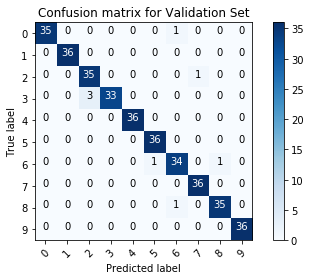

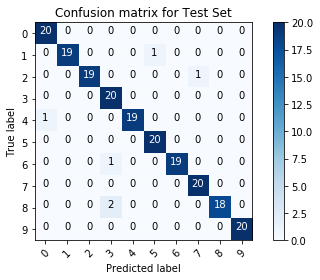

In [11]:
from sklearn.metrics import confusion_matrix

labels = list(range(10))

conf_mat_val = confusion_matrix(y_val, y_pred_val)
plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

conf_mat_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

## Βήμα 14
1. Από τα [help scripts](http://mycourses.ntua.gr/projects/goto/index.php/pr_lab2_2019-20_help_scripts.zip) έχουμε:

In [12]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn

class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        
        self.lengths = [feat.shape[0] for feat in feats]
        
        self.num_sequences = len(feats)
        self.max_sequence_length = max(self.lengths)
        self.feature_dimension = feats[0].shape[1]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        
        padded = np.array([np.pad(feat.reshape(-1),
                            (0, (self.max_sequence_length - length)*self.feature_dimension), 'constant')
                            .reshape(self.max_sequence_length, self.feature_dimension) 
                            for feat, length in zip(x, self.lengths)])
        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)

2. Για το απλό `LSTM` δίκτυο έχουμε:

In [13]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.0, num_layers=1, bidirectional=False):
        super(BasicLSTM, self).__init__()
        
        self.dropout_prob = dropout_prob
        self.bidirectional = bidirectional
        self.feature_size = hidden_dim * 2 if self.bidirectional else hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                                dropout=dropout_prob, batch_first=True, bidirectional= bidirectional)
        
        self.fc = nn.Linear(self.feature_size, self.output_dim)
        

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
                 
        # --------------- Insert your code here ---------------- #
        
        N, L, D = x.size()
        
        out, (hidden, cell) = self.lstm(x)
        
        last = self.last_timestep(out, lengths)
        
        last_outputs = self.fc(last)
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
              
        return last_outputs
    
    

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)
        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [14]:
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, f1_score

BATCH_SIZE = 40
EPOCHS = 1

fld_train = FrameLevelDataset(X_train, y_train.tolist())
fld_val = FrameLevelDataset(X_val, y_val.tolist())
fld_test = FrameLevelDataset(X_test, y_test.tolist())

train_loader = DataLoader(fld_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(fld_val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(fld_test, batch_size=BATCH_SIZE, shuffle=True)


# for epoch in range(EPOCHS):

print(fld_train.num_sequences,
fld_train.max_sequence_length,
fld_train.feature_dimension)
# print(fld_test.num_sequences,
# fld_test.max_sequence_length,
# fld_test.feature_dimension)

hidden_dim = 20

model =  BasicLSTM(input_dim=6, hidden_dim=hidden_dim, output_dim=10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)



for epoch in range(10):
    
    model.train()

    loss = 0.0
    for batch in train_loader:

        inputs, targets, lengths = batch

        inputs = Variable(inputs)
        targets = Variable(targets)
        lengths = Variable(lengths)

        outputs = model(inputs, lengths)
        
        loss += criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    print("epoch: %d, train loss: %1.4f" % (epoch + 1, loss.data/(inputs.size(0)*BATCH_SIZE)))
    
    model.eval()
    
    loss = 0.0
    with torch.no_grad():
        for batch in val_loader:

            inputs, targets, lengths = batch

            inputs = Variable(inputs)
            targets = Variable(targets)
            lengths = Variable(lengths)

            outputs = model(inputs, lengths)
            
#             accuracy += accuracy(outputs, targets)
            
#             print(accuracy_score(targets, outputs))
            
#             print(outputs)

#         loss += criterion(outputs, targets)

1440 153 6
epoch: 1, train loss: 0.0523
epoch: 2, train loss: 0.0492
epoch: 3, train loss: 0.0426
epoch: 4, train loss: 0.0373


KeyboardInterrupt: 

4. Για την εκπαίδευση του μοντέλου στο train set και την εκτίμηση στο validation set έχουμε:

In [15]:
import math
import sys

def progress(loss, epoch, batch, batch_size, dataset_size):
    """
    Print the progress of the training for each epoch
    """
    batches = math.ceil(float(dataset_size) / batch_size)
    count = batch * batch_size
    bar_len = 40
    filled_len = int(round(bar_len * count / float(dataset_size)))

    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    status = 'Epoch {}, Loss: {:.4f}'.format(epoch, loss)
    _progress_str = "\r \r [{}] ...{}".format(bar, status)
    sys.stdout.write(_progress_str)
    sys.stdout.flush()

    if batch == batches:
        print()

In [16]:
import torch
from torch.autograd import Variable

def train_dataset(_epoch, dataloader, model, loss_function, optimizer):
    
    model.train()
    running_loss = 0.0

    # obtain the model's device ID
    device = next(model.parameters()).device

    for index, batch in enumerate(dataloader, 1):

        # get the inputs (batch)
        inputs, labels, lengths = batch

        # move the batch tensors to the right device
        inputs = Variable(inputs).to(device)
        labels = Variable(labels).to(device)
        lengths = Variable(lengths).to(device)

        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        outputs = model(inputs, lengths)

        # Step 3 - compute loss: L = loss_function(y, y')
        loss = loss_function(outputs, labels)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        running_loss += loss.data.item()

        # print statistics
        progress(loss=loss.data.item(),
                 epoch=_epoch,
                 batch=index,
                 batch_size=dataloader.batch_size,
                 dataset_size=len(dataloader.dataset))

    return running_loss / index


def eval_dataset(dataloader, model, loss_function):
    
    # IMPORTANT: switch to eval mode
    # disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()
    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):

            # get the inputs (batch)
            inputs, labels, lengths = batch

            # Step 1 - move the batch tensors to the right device
            inputs = Variable(inputs).to(device)
            labels = Variable(labels).to(device)
            lengths = Variable(lengths).to(device)

            # Step 2 - forward pass: y' = model(x)
            outputs = model(inputs, lengths)

            # Step 3 - compute loss.
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            loss = loss_function(outputs, labels)

            # Step 4 - make predictions (class = argmax of posteriors)
            _, posibol = torch.max(outputs.data, 1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.extend(list(posibol.data.cpu().numpy().squeeze()))
            y.extend(list(labels.data.cpu().numpy().squeeze()))


            running_loss += loss.data.item()

    return running_loss / index, (y_pred, y)

In [17]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [18]:
from sklearn.metrics import accuracy_score, f1_score
import time

def train_and_val_model(EPOCHS, train_loader, val_loader, model, loss_function, optimizer, 
                                                        save=False, early_stopping_limit=0):

    total_train_loss = []
    total_val_loss = []
    min_val_loss = 100
    
    if early_stopping_limit:
        early_stopping = EarlyStopping(patience=early_stopping_limit, verbose=True)
    
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        # train the model for one epoch
        train_dataset(epoch, train_loader, model, loss_function, optimizer)

        # evaluate the performance of the model
        train_loss, (y_train_pred, y_train_gold) = eval_dataset(train_loader, model, loss_function)
        print("Train Set: loss = {:.4f}".format(train_loss))

        val_loss, (y_val_pred, y_val_gold) = eval_dataset(val_loader, model, loss_function)
        print("Validation Set: loss = {:.4f}\n".format(val_loss))
        test_model(val_loader, model, loss_function, "Eval")

        
        # save best model
#         if (val_loss < min_val_loss and save):
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': val_loss}, MODEL_PATH)
#             min_val_loss = val_loss

        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
        
        if early_stopping_limit:
            early_stopping(val_loss, model)
        
            if early_stopping.early_stop:
                print("Early stopping...")
                break

    if early_stopping_limit:        
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
        
    print("\nTotal train and validation time: {:.2f} seconds".format((time.time() - start_time)))
    
    return total_train_loss, total_val_loss


def test_model(test_loader, model, loss_function, set):
    
    test_loss, (y_test_pred, y_test_gold) = eval_dataset(test_loader, model, loss_function)
    print("\n"+set+" Set: loss={:.4f}, accuracy={:.4f}, f1-macro={:.4f}".format(test_loss, accuracy_score(y_test_gold, y_test_pred), f1_score(y_test_gold, y_test_pred, average='macro')))
    
    return y_test_pred, y_test_gold

Χρησιμοποιώντας την κλάση ```FrameLevelDataset``` έχουμε:

In [19]:
fld_train = FrameLevelDataset(X_train, y_train.tolist())
fld_val = FrameLevelDataset(X_val, y_val.tolist())
fld_test = FrameLevelDataset(X_test, y_test.tolist())

Για την εκπαίδευση του δικτύου, χωρίζουμε τα `train`, `validation` και `test` set σε batches με $batch\_size = 40$. Εκπαιδεύουμε το δίκτυο για $30$ εποχές και χρησιμοποιώντας ως loss function την ```CrossEntropyLoss()``` (η οποία εκτελεί εσωτερικά ```softmax()```) και για optimizer τον `Stochastic Gradient Descent` (```SGD()```)

In [20]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 40
EPOCHS = 30

train_loader = DataLoader(fld_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(fld_val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(fld_test, batch_size=BATCH_SIZE, shuffle=True)

# print([x for x in train_loader])

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

# if os.path.exists("./train.model"):
    #     model.load_state_dict(torch.load("./train.model"))
    #     # model.eval()
    #     print("Loaded from pre-trained model")

# torch.save(model.state_dict(), "./train.model")

DEVICE: cuda
cuda Version: 10.1.243 
n_cuda = 1 
Cuda Name(s): GeForce GTX 1050 Ti with Max-Q Design


In [24]:
model = BasicLSTM(input_dim=6, hidden_dim=20, output_dim=10).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

total_train_loss, total_val_loss = train_and_val_model(50, train_loader, val_loader, model, 
                                                        loss_function, optimizer, early_stopping_limit=7)

 [========================================] ...Epoch 1, Loss: 1.5645
Train Set: loss = 1.3620
Validation Set: loss = 1.4053


Eval Set: loss=1.4053, accuracy=0.4389, f1-macro=0.3689
Validation loss decreased (inf --> 1.405315).  Saving model ...
 [========================================] ...Epoch 2, Loss: 1.2295
Train Set: loss = 0.9370
Validation Set: loss = 0.9657


Eval Set: loss=0.9657, accuracy=0.6833, f1-macro=0.6757
Validation loss decreased (1.405315 --> 0.965650).  Saving model ...
 [========================================] ...Epoch 3, Loss: 0.5979
Train Set: loss = 0.6440
Validation Set: loss = 0.7190


Eval Set: loss=0.7190, accuracy=0.7417, f1-macro=0.7372
Validation loss decreased (0.965650 --> 0.719005).  Saving model ...
 [========================================] ...Epoch 4, Loss: 0.4967
Train Set: loss = 0.4679
Validation Set: loss = 0.5577


Eval Set: loss=0.5577, accuracy=0.8278, f1-macro=0.8238
Validation loss decreased (0.719005 --> 0.557749).  Saving model ...
 

In [23]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Test Set: loss=0.2038, accuracy=0.9250, f1-macro=0.9254


## y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")

5. Με την χρήση `Dropout Layer` καθώς και `L2 Regularization` (Ridge Regression) έχουμε:

In [144]:
model = BasicLSTM(input_dim=6, hidden_dim=20, output_dim=10, dropout_prob=0.2).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer_L2 = torch.optim.SGD(model.parameters(), lr=1e-0, weight_decay=1e-5)


total_train_loss, total_val_loss = train_and_val_model(10, train_loader, val_loader, model, loss_function, optimizer_L2)

 [========================================] ...Epoch 1, Loss: 1.5049
Train Set: loss = 1.3857
Validation Set: loss = 1.4163


Eval Set: loss=1.4163, accuracy=0.5444, f1-macro=0.5472
 [========================================] ...Epoch 2, Loss: 0.9212
Train Set: loss = 0.9040
Validation Set: loss = 0.8726


Eval Set: loss=0.8726, accuracy=0.6639, f1-macro=0.6416
 [========================================] ...Epoch 3, Loss: 0.7727
Train Set: loss = 0.6115
Validation Set: loss = 0.6469


Eval Set: loss=0.6469, accuracy=0.7806, f1-macro=0.7781
 [========================================] ...Epoch 4, Loss: 0.5479
Train Set: loss = 0.6705
Validation Set: loss = 0.7030


Eval Set: loss=0.7030, accuracy=0.7222, f1-macro=0.7087
 [========================================] ...Epoch 5, Loss: 0.3805
Train Set: loss = 0.3567
Validation Set: loss = 0.3786


Eval Set: loss=0.3786, accuracy=0.9056, f1-macro=0.9064
 [========================================] ...Epoch 6, Loss: 0.3397
Train Set: loss = 0.3

In [145]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Test Set: loss=0.2362, accuracy=0.9350, f1-macro=0.9359


6. Με την χρήση `Early Stopping` και `Checkpoints` έχουμε:

7. Για το `Bidirectional LSTM` δίκτυο έχουμε:

In [25]:
model = BasicLSTM(input_dim=6, hidden_dim=20, output_dim=10, bidirectional=True).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer_L2 = torch.optim.SGD(model.parameters(), lr=1e-0)


total_train_loss, total_val_loss = train_and_val_model(20, train_loader, val_loader, model, loss_function, optimizer_L2)

 [========================================] ...Epoch 1, Loss: 1.3060
Train Set: loss = 1.3569
Validation Set: loss = 1.3862


Eval Set: loss=1.3862, accuracy=0.4889, f1-macro=0.4517
 [========================================] ...Epoch 2, Loss: 1.5336
Train Set: loss = 1.1788
Validation Set: loss = 1.2574


Eval Set: loss=1.2574, accuracy=0.5167, f1-macro=0.4721
 [========================================] ...Epoch 3, Loss: 0.6422
Train Set: loss = 0.6928
Validation Set: loss = 0.7615


Eval Set: loss=0.7615, accuracy=0.7083, f1-macro=0.7098
 [========================================] ...Epoch 4, Loss: 0.5866
Train Set: loss = 0.5230
Validation Set: loss = 0.6396


Eval Set: loss=0.6396, accuracy=0.7778, f1-macro=0.7766
 [========================================] ...Epoch 5, Loss: 0.5614
Train Set: loss = 0.4084
Validation Set: loss = 0.4735


Eval Set: loss=0.4735, accuracy=0.8611, f1-macro=0.8602
 [========================================] ...Epoch 6, Loss: 0.4171
Train Set: loss = 0.3

In [153]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Test Set: loss=0.1690, accuracy=0.9600, f1-macro=0.9601


8. (Bonus) Με χρήση pack_padded_sequence στην εκπαίδευση του μοντέλου:

Για το καλύτερο μοντέλο μετά την εκπαίδευση έχουμε:

In [95]:
def plot_loss(total_epochs, train_loss, val_loss):
    
    plt.title("Train and Validation")
    plt.xlabel("Epochs")
    plt.plot(total_epochs, train_loss, 'o-', color="r",
             label="Training Loss")
    plt.plot(total_epochs, val_loss, 'o-', color="g",
             label="Validation Loss")
    plt.xticks(np.arange(0, EPOCHS+1, step=5))
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [92]:
from sklearn.metrics import confusion_matrix

y_val_pred, y_val_gold = test_model(val_loader, model, loss_function, "Validation")
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Validation Set: loss=0.2505, accuracy=0.9444, f1-macro=0.9444

Test Set: loss=0.2216, accuracy=0.9600, f1-macro=0.9603


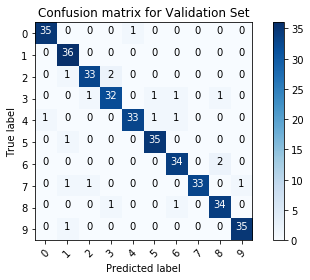

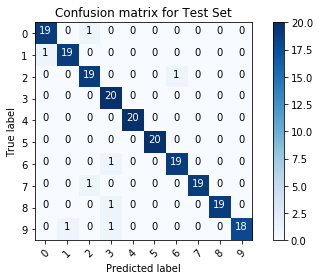

In [93]:
labels = list(range(10))

conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

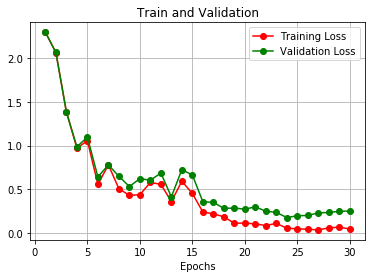

In [96]:
plot_loss(np.arange(1, EPOCHS+1), total_train_loss, total_val_loss)